# The Elliptic CurveVisualizer

This notebook contains functions to visualize Short Weierstrass elliptic curves.

## Utils

In [77]:
# Imports.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [235]:
""" Helpers. """

def evaluate_curve(x, y_squared_func):
    y_squared = y_squared_func(x)
    y_squared_is_pos = y_squared >= 0
    x_filtered = x[y_squared_is_pos]
    y_pos = np.sqrt(y_squared[y_squared_is_pos])
    y_neg = -y_pos
    
    # Draw a line to connect the positive and negative halves so it doesn't appear disjointed.
    x_near_zero = np.array([x_filtered[0], x_filtered[0]])
    y_near_zero = np.array([y_pos[0], y_neg[0]])
    
    return x_filtered, y_pos, y_neg, x_near_zero, y_near_zero

def graph_curve(y_squared_func, x_range, y_range, name='elliptic curve', x_count=10_000):
    """ Graphs elliptic curve with the upper half of it provided as a function. """
    x = np.linspace(x_range[0], x_range[1], x_count)
    x_filtered, y_pos, y_neg, x_near_zero, y_near_zero = evaluate_curve(x, y_squared_func)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x_filtered, y_pos, 'b')
    ax.plot(x_filtered, y_neg, 'b')
    ax.plot(x_near_zero, y_near_zero, 'b')
    
    ax.set_title(name)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)

    return ax

a_slider = None # The slider has to be kept globally for some reason.
b_slider = None # The slider has to be kept globally for some reason.

def graph_sw_curve_slider(x_range, y_range, a_range, b_range, name='Short Weierstrass curve', x_count=10_000):
    global a_slider
    global b_slider
    
    def y_squared_func(x, a, b):
        return x**3 + a * x + b
    
    def slider_on_changed(val):
        y_squared_curr = lambda x: y_squared_func(x, a_slider.val, b_slider.val)
        x_filtered, y_pos, y_neg, x_near_zero, y_near_zero = evaluate_curve(x, y_squared_curr)
        
        pos.set_xdata(x_filtered)
        pos.set_ydata(y_pos)
        neg.set_xdata(x_filtered)
        neg.set_ydata(y_neg)
        zero.set_xdata(x_near_zero)
        zero.set_ydata(y_near_zero)
        fig.canvas.draw_idle()
        
    x = np.linspace(x_range[0], x_range[1], x_count)
    y_squared_init = lambda x: y_squared_func(x, np.mean(a_range), np.mean(b_range))
    x_filtered, y_pos, y_neg, x_near_zero, y_near_zero = evaluate_curve(x, y_squared_init)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.subplots_adjust(bottom=0.25)
    ax.margins(x=0)

    [pos] = ax.plot(x_filtered, y_pos, 'b')
    [neg] = ax.plot(x_filtered, y_neg, 'b')
    [zero] = ax.plot(x_near_zero, y_near_zero, 'b')

    ax.set_title(name)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)

    a_slider_ax  = fig.add_axes([0.2, 0.1, 0.65, 0.03])
    a_slider = Slider(a_slider_ax, 'a', a_range[0], a_range[1], valinit=np.mean(a_range))
    a_slider.on_changed(slider_on_changed)
    
    b_slider_ax  = fig.add_axes([0.2, 0.05, 0.65, 0.03])
    b_slider = Slider(b_slider_ax, 'b', b_range[0], b_range[1], valinit=np.mean(b_range))
    b_slider.on_changed(slider_on_changed)

    plt.show()

def get_line_ys(xs, x1, y1, x2, y2):
    line_eqn = lambda x: ((y2 - y1) / (x2 - x1)) * (x - x1) + y1
    return line_eqn(xs)
    
def get_intersections(ax, x, f, g):
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    return idx

def float_equal(a, b):
    return np.abs(a - b) < 1e-2
    
def plot_addition(ax, y_squared_func, p1, p2, x_range, colors=['g', 'c', 'r'], x_count=10_000):
    x = np.linspace(x_range[0], x_range[1], x_count)
    
    x_filtered, y_pos, y_neg, _, _ = evaluate_curve(x, y_squared_func)

    [x1, sign1] = p1
    [x2, sign2] = p2
    
    y1 = sign1 * np.sqrt(y_squared_func(x1))
    y2 = sign2 * np.sqrt(y_squared_func(x2))
    
    y = get_line_ys(x, x1, y1, x2, y2)
    y_filtered = get_line_ys(x_filtered, x1, y1, x2, y2)
    
    idx_pos = get_intersections(ax, x_filtered, y_pos, y[len(y) - len(y_pos):])
    idx_neg = get_intersections(ax, x_filtered, y_neg, y[len(y) - len(y_pos):])
    
    for point in idx_pos:
        if not float_equal(x_filtered[point], x1) and not float_equal(x_filtered[point], x2):
            x3 = x_filtered[point]
            y3 = y_filtered[point]
            break
    for point in idx_neg:
        if not float_equal(x_filtered[point], x1) and not float_equal(x_filtered[point], x2):
            x3 = x_filtered[point]
            y3 = y_filtered[point]
            break
    
    ax.plot(x, y, color=colors[0])
    ax.plot([x3, x3], [y3, -y3], color=colors[1])
    
    ax.plot(x_filtered[idx_pos], y_filtered[idx_pos], 'o', color=colors[2])
    ax.plot(x_filtered[idx_neg], y_filtered[idx_neg], 'o', color=colors[2])
    ax.plot(x3, -y3, 'o', color=colors[2])
    
    return (x1, y1), (x2, y2), (x3, y3)


## Display Elliptic Curve

In [111]:
# Parameters of curve.
a = -5
b = 8

def y_squared(x):
    return x**3 + a * x + b

x_range = [-3, 5]
y_range = [-10, 10]
name = 'Short Weierstrass curve with a=-5, b=8'

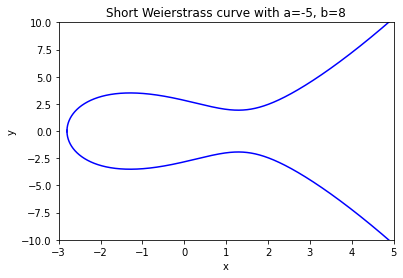

In [112]:
%matplotlib inline
graph_curve(y_squared, x_range, y_range, name)
plt.show()

<IPython.core.display.Javascript object>


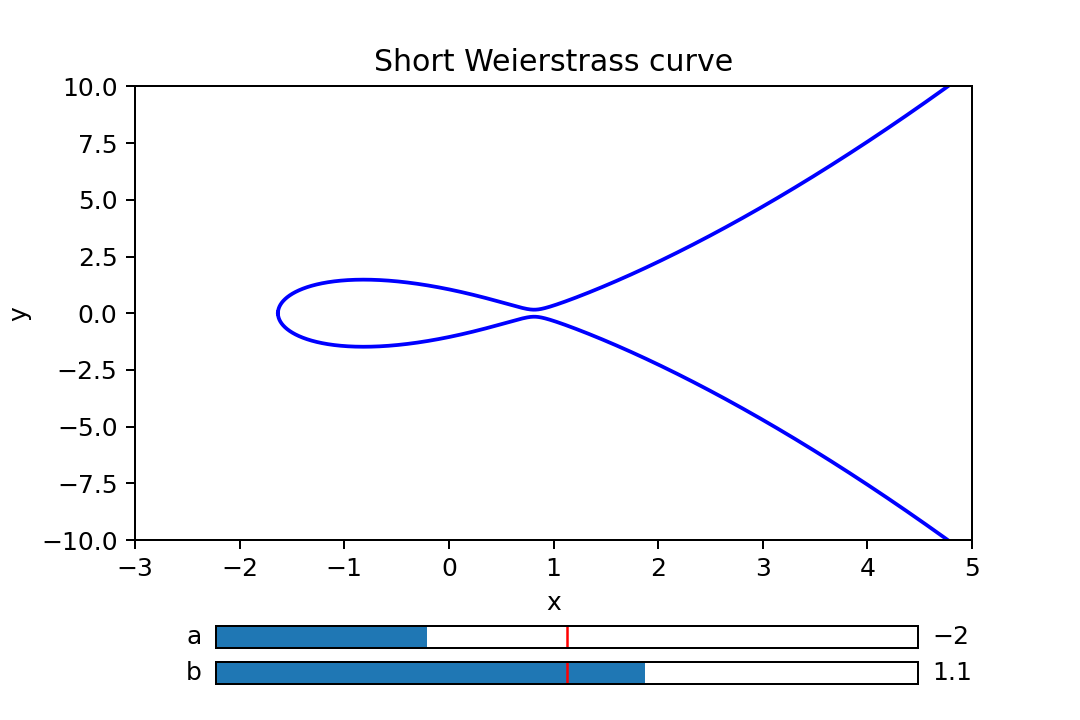

In [113]:
%matplotlib notebook
graph_sw_curve_slider(x_range, y_range, [-5, 5], [-5, 5])

## Visualize Elliptic Curve Addition

The following plots show an example of elliptic curve addition being associative: $(A+B)+C=A+(B+C)$

In [238]:
# Parameters of curve.
a = -5
b = 8

def y_squared(x):
    return x**3 + a * x + b

x_range = [-3, 5]
y_range = [-10, 10]
name = 'Short Weierstrass curve with a=-5, b=8'

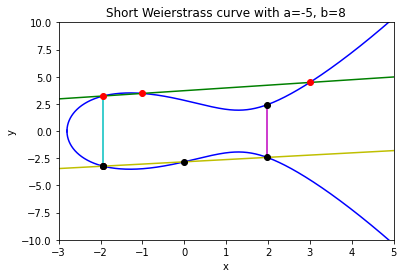

((-1, 3.4641016151377544) + (3, 4.47213595499958)) + (0, -2.8284271247461903) = (1.9788978897889793, -2.4202468479048527)


In [246]:
# -1 + 3
%matplotlib inline
ax = graph_curve(y_squared, x_range, y_range, name)
p1, p2, p6 = plot_addition(ax, y_squared, [-1, 1], [3, 1], x_range)

# (-1 + 3) + 0
_, p3, p4 = plot_addition(ax, y_squared, [p6[0], -1], [0, -1], x_range, ['y', 'm', 'k'])
plt.show()
print(f'({p1} + {p2}) + {p3} = {p4}')

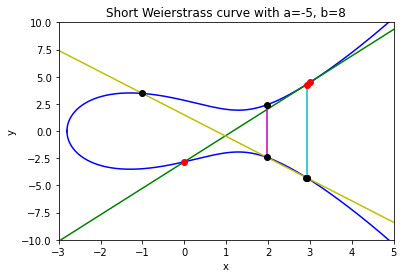

((-1, 3.4641016151377544) + (3, 4.47213595499958)) + (0, -2.8284271247461903) = (1.9788978897889793, -2.4193821383183263)


In [244]:
# 3 + 0
ax = graph_curve(y_squared, x_range, y_range, name)
_, _, p7 = plot_addition(ax, y_squared, [3, 1], [0, -1], x_range)

# -1 + (3 + 0)
_, _, p5 = plot_addition(ax, y_squared, [-1, 1], [p7[0], -1], x_range, ['y', 'm', 'k'])
plt.show()
print(f'{p1} + ({p2} + {p3}) = {p5}')